In [228]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [131]:
df = pd.read_csv('2018-2021_comptage-velo-donnees-compteurs.csv')

In [ ]:
df.head(2)

# Exploration des données du dataset 2018-2021_comptage-velo-donnees-compteurs.csv

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.telerama.fr/sites/tr_master/files/styles/968x546/public/medias/2016/09/media_147106/lara-croft-la-momie-ou-benjamin-gates-que-valent-les-heritiers-d-indiana-jones%2CM370996.jpg?itok=Q_Lue4eO")

Pour que ce soit plus clair, on va definir pour chaque valeur des variables 'Dweek_Date_Count' et 'M_Date_Count' respectivement les jours et les mois.

In [132]:
df['Dweek_Date_Count'].replace({0: 'Lundi',
                                1: 'Mardi',
                                2: 'Mercredi',
                                3: 'Jeudi',
                                4: 'Vendredi',
                                5: 'Samedi',
                                6: 'Dimanche'}, inplace=True)

df['M_Date_Count'].replace({1: 'Janvier',
                            2: 'Fevrier',
                            3: 'Mars',
                            4: 'Avril',
                            5: 'Mai',
                            6: 'Juin', 
                            7: 'Juillet',
                            8: 'Aout', 
                            9: 'Septembre', 
                            10: 'Octobre', 
                            11: 'Novembre',
                            12: 'Decembre'}, inplace=True)

Maintenant essayons d'observer la distribution de la variable 'Count_by_hour' en fonction des jours de la semaine

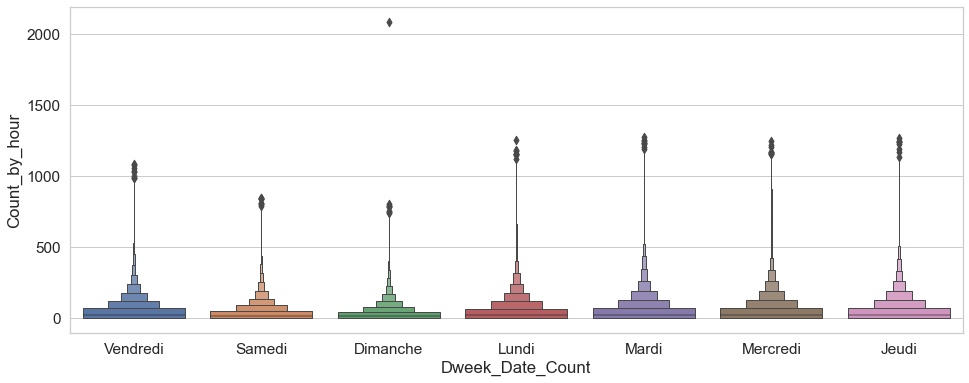

In [12]:
plt.figure(figsize=(16, 6))
sns.boxenplot(x='Dweek_Date_Count', y='Count_by_hour', data=df);

On remarque qu'on à un point à 2088 abbérant, on va donc le supprimer.

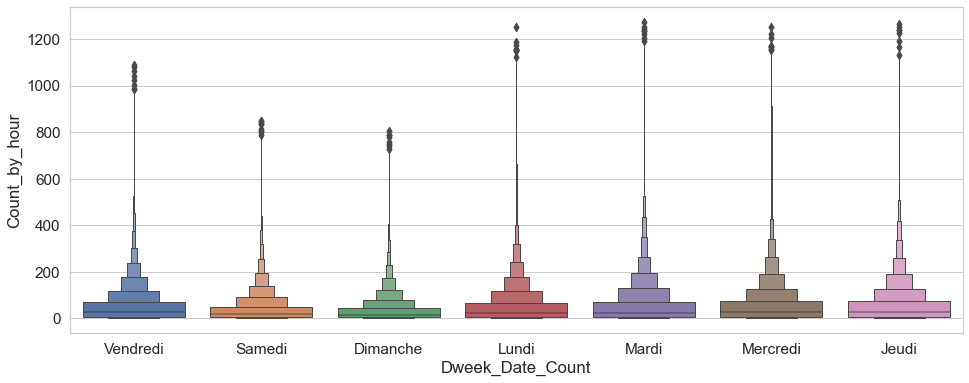

In [25]:
df = df[df.Count_by_hour != 2088] # supréssion de la valeur abérante
plt.figure(figsize=(16, 6))
sns.boxenplot(x='Dweek_Date_Count', y='Count_by_hour', data=df);

Voila c'est un peu mieux maintenant !

Alors maintenant qu'on a la distribution pour chaque jour de la semaine et pour toutes les dates confondues, ce qui serait intéressant c'est d'observer pour un jour bien précis quelle est la distribution d'un seul et unique compteur en fonction de l'heure de la journée. On arrivera peut-être à reconnaitre une forme type de distribution probabilistique connue.

On va d'abord commencer par trier les valeurs pour connaitre le top 3 des compteurs, et pourquoi ne pas regarder le nombre de velo pour le lundi 4 février 2019 par exemple :D

In [10]:
df040219 = df[df.M_Date_Count == 'Fevrier']
df040219 = df040219[df.D_Date_Count == 4]
df040219 = df040219[df.Y_Date_Count == 2019]


pd.pivot_table(df040219, index='Address', aggfunc='sum').sort_values(by='Count_by_hour', ascending=False).head(3)

Count_by_hour  D_Date_Count  D_Date_Instal  \
Address                                                                     
89 boulevard de Magenta NO-SE         1847.0            96            672   
Face au 48 quai de la marne           1785.0           192           1392   
102 Bd magenta SE-NO                  1649.0            96            696   

                               H_Date_Count          Id  Latitude  Longitude  \
Address                                                                        
89 boulevard de Magenta NO-SE           276  2401140792  1173.072     56.496   
Face au 48 quai de la marne             552  4802282016  2346.768    114.528   
102 Bd magenta SE-NO                    276  2401140864  1173.072     56.520   

                               M_Date_Instal  Source  Unnamed: 0  \
Address                                                            
89 boulevard de Magenta NO-SE            264   48456     5338036   
Face au 48 quai de la marne              528   96912     9187923   
102 Bd magenta SE-NO                     264   48456     4733726   

                               Y_Date_Count  Y_Date_Instal  
Address                                                     
89 boulevard de Magenta NO-SE         48456          48432  
Face au 48 quai de la marne           96912          96864  
102 Bd magenta SE-NO                  48456          48432

Le 89 boulevard de Magenta NO-SE à l'air pas mal pour commencer à observer la distribution :)

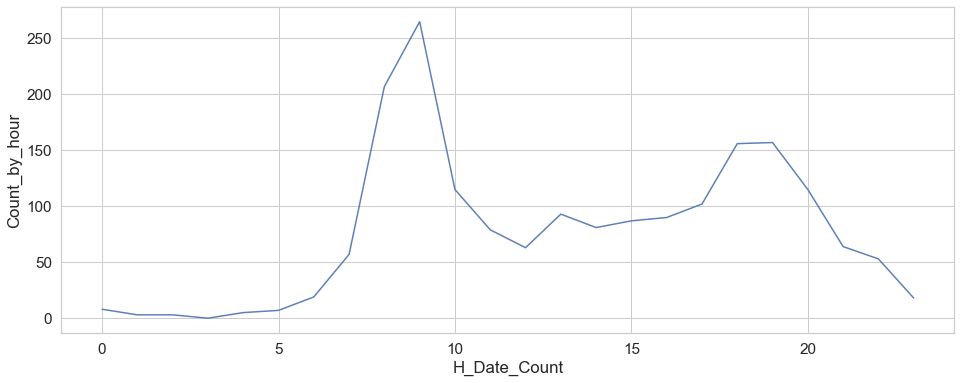

In [12]:
df040219 = df040219[df.Address == "89 boulevard de Magenta NO-SE"]

plt.figure(figsize=(16, 6))
sns.lineplot(x='H_Date_Count', y='Count_by_hour', alpha=0.9, data=df040219);

Ok donc on remarque bien deux mouvements un le matin et l'autre l'aprés-midi. Ca ressemble à deux gaussiennes qui sont confondues. Essayons d'observer la densité de cette distribution

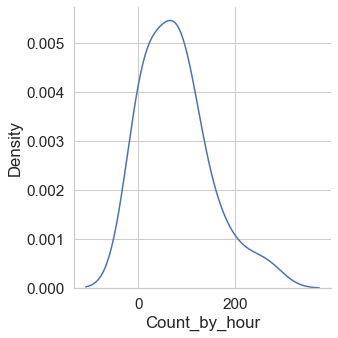

In [23]:
sns.displot(x='Count_by_hour', kind='kde', data=df040219);

La distribution ne suit pas vraiment une gaussienne mais essayons de faire un test statistique pour en être certains

In [24]:
import scipy.stats as stats
from scipy.stats import shapiro

stat, p = shapiro(df040219['Count_by_hour'])
print(' Stat=%.3f, p-val=%.5f' % (stat, p))

 Stat=0.899, p-val=0.02021


La valeur Stat est proche de 0.9 mais la p-value n'est pas strictement supérieur à 5% dommage ... 
On à plutôt deux gaussiennes, une le matin et l'autre l'aprés-midi. On peut toujours essayer de séparer les valeurs et refaire le test statistique

Pour la distribution du matin : Statistics=0.765, p=0.00273
Pour la distribution de l'aprés midi : Statistics=0.955, p=0.70315


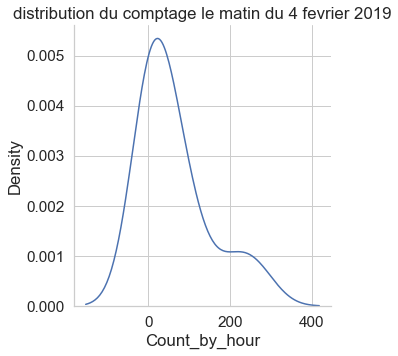

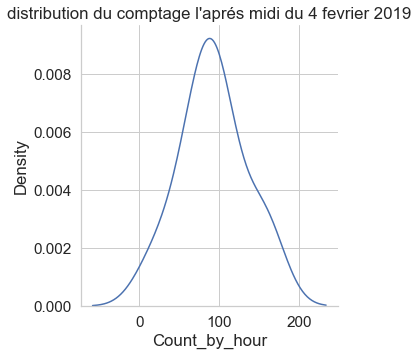

In [25]:
df040219AM = df040219[df.H_Date_Count <= 12]
df040219PM = df040219[(df040219['H_Date_Count'] > 12) & (df040219['H_Date_Count'] <=23)]

sns.displot(x='Count_by_hour', kind='kde', data=df040219AM)
plt.title('Distribution du comptage le matin du 4 fevrier 2019');

sns.displot(x='Count_by_hour', kind='kde', data=df040219PM)
plt.title("Distribution du comptage l'aprés midi du 4 fevrier 2019");

stat, p = shapiro(df040219AM['Count_by_hour'])
print('Pour la distribution du matin : Statistics=%.3f, p=%.5f' % (stat, p))

stat, p = shapiro(df040219PM['Count_by_hour'])
print("Pour la distribution de l'aprés midi : Statistics=%.3f, p=%.5f" % (stat, p))

On à une p-value supérieur à 5% pour l'aprés midi, toutefois ce n'est pas vraiment le cas le matin. Essayons 
maintenant d'observer si tous les autres jours de la semaine au mois de février on a les mêmes formes de distribution ?

<Figure size 864x432 with 0 Axes>

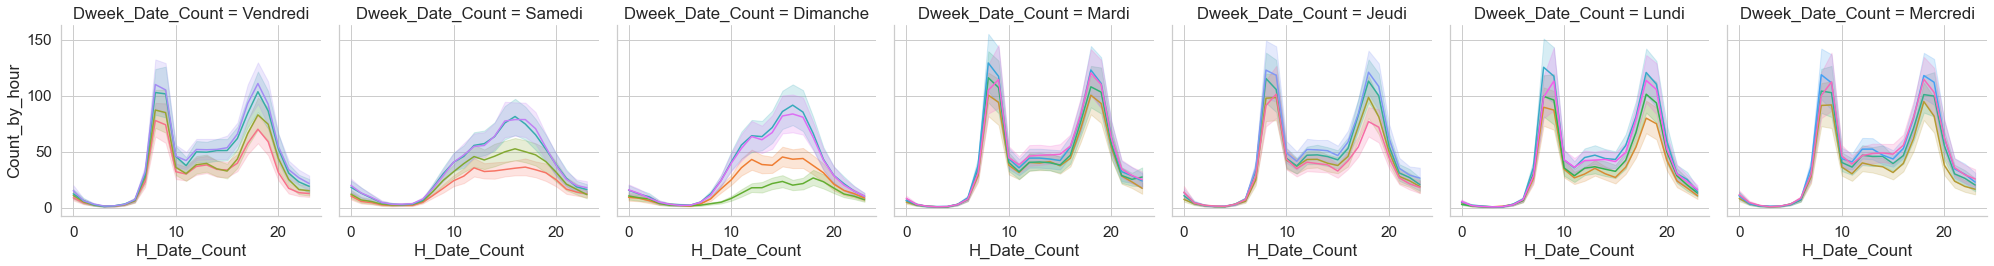

In [30]:
df_Fev19 = df[df.M_Date_Count == 'Fevrier']
df_Fev19 = df_Fev19[df_Fev19.Y_Date_Count == 2019]

plt.figure(figsize=(12, 6))
g = sns.FacetGrid(data=df_Fev19, col="Dweek_Date_Count", hue='D_Date_Count', height=4)
g.map(sns.lineplot, "H_Date_Count", "Count_by_hour");

Intéressant on observe que le samedi et le dimanche n'ont pas les mêmes horaires d'affluence, logique. Et le reste de l'année ?

<Figure size 576x432 with 0 Axes>

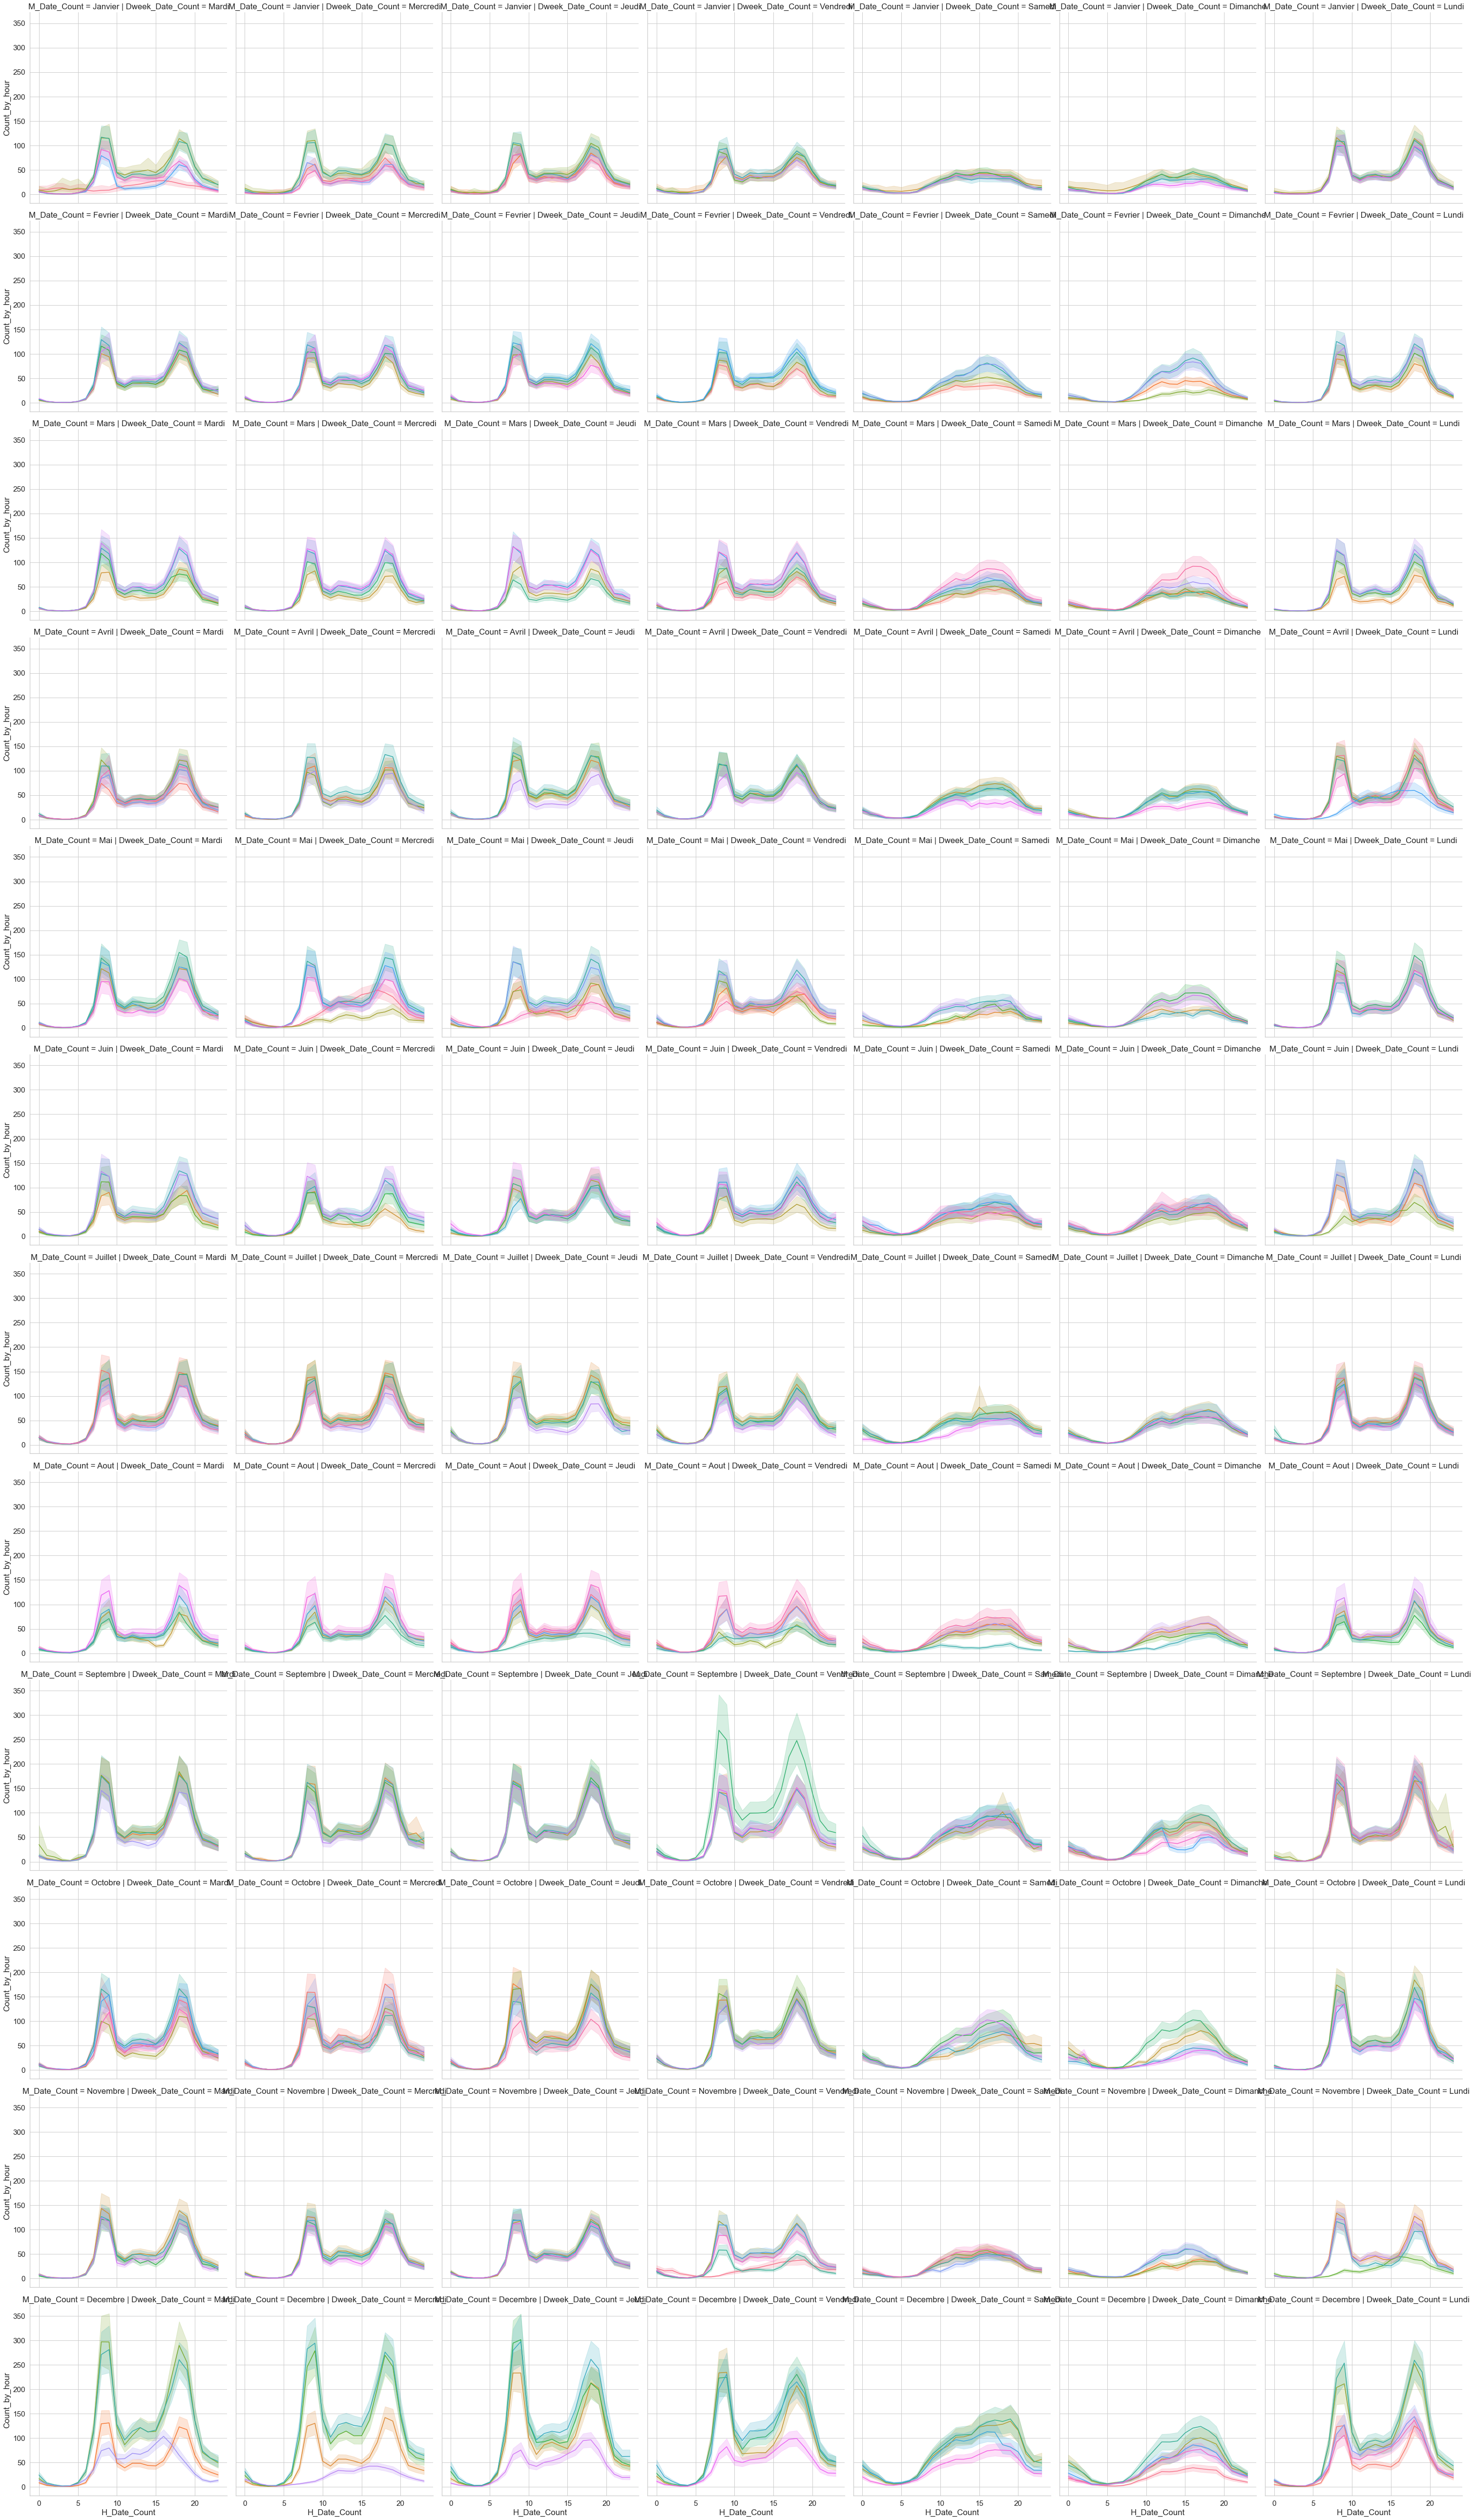

In [32]:
df_2019 = df[df.Y_Date_Count == 2019]

plt.figure(figsize=(8, 6))
g = sns.FacetGrid(data=df_2019, row = 'M_Date_Count', col="Dweek_Date_Count", hue='D_Date_Count', height=6)
g.map(sns.lineplot, "H_Date_Count", "Count_by_hour");

C'est aussi le cas pour tout le reste de l'année pour le samedi et dimanche. On a malgré tous quelques jours particuliers qui se distinguent avec une distribution des valeurs nettement différentes. Certainement des jours fériés, événements particuliers ou autres. Idéalement, il faudrait essayer de faire un test statistique pour chaque demi-journée.

In [133]:
# Fonction am ou pm pour défnir selon l'horaire la matinée ou l'aprés-midi
def amORpm(row):
    if row['H_Date_Count'] <= 12:
        val = 'AM'
    else:
        val = 'PM'
    return val

# Duplication de la colonne H_Date_Count
df['AM_PM'] = df['H_Date_Count'] 

# Acpplication de la fonction amORpm
df['AM_PM'] = df.apply(amORpm, axis=1)

In [134]:
# Suppréssion des colonnes non utiles
dfg = df.drop(['Unnamed: 0',
               'Id_old', 
               'Address_old', 
               'Id', 'Date_instal', 
               'Photo_old', 
               'Coord_old', 
               'Source', 
               'Latitude', 
               'Longitude', 
               'Coord', 
               'Direction', 
               'Y_Date_Instal', 
               'M_Date_Instal', 
               'D_Date_Instal'], axis=1)

# Séparation des données de la colonne Date_count
dfg[['Date','Hour']] = df.Date_count.str.split(" ", expand=True)

In [ ]:
# Création de la liste de toutes les adresses des compteurs
listOfAdress = dfg['Address'].unique()

# Création d'un df pour les données de test statistique pour le matin
dfStatTesAM = pd.DataFrame(columns=['Address', 'Date', 'stat', 'p-val'])

# Création d'un df pour les données de test statistique pour l'aprés-midi
dfStatTesPM = pd.DataFrame(columns=['Address', 'Date', 'stat', 'p-val'])

for element in listOfAdress:
    # chaque element est une adresse de compteur
    temp_df = dfg[dfg.Address == element]

    # on cherche les date pour le df temporaire du compteur en cours
    listOfDate = temp_df['Date'].unique()    
    
    
    # pour chaque l'adresse on cherche les valeurs unique de dates
    for date in listOfDate:
        temp_df = temp_df[temp_df.Date == date]
              
        
    # Enregistrement des valeurs statistique pour le matin uniquement
        temp_df1 = temp_df[temp_df.AM_PM == 'AM']
        
#         print('AM', element, date, temp_df1.shape)
        
        if temp_df1.shape[0] != 0 and temp_df1.shape[0] > 3:
            stat, p = shapiro(temp_df1['Count_by_hour'])
            
            dfStatTesAM = dfStatTesAM.append({'Address':element, 
                                              'Date': date, 
                                              'Stat': stat, 
                                              'p_val': p}, ignore_index=True)
        
    # Enregistrement des valeurs statistique pour l'aprés-midi uniquement
        temp_df2 = temp_df[temp_df.AM_PM == 'PM']
        
#         print('PM', element, date, temp_df2.shape)
        
        if temp_df2.shape[0] != 0 and temp_df2.shape[0] > 3:
            stat, p = shapiro(temp_df2['Count_by_hour'])
            
            dfStatTesPM = dfStatTesPM.append({'Address':element, 
                                              'Date': date, 
                                              'Stat': stat, 
                                              'p_val': p}, ignore_index=True)
            
    # Reset de temp_df sur l'adresse du compteur
            temp_df = dfg[dfg.Address == element]

On dénombre 4039 p-value inférieur à 5% et 2377 supérieur à 5%


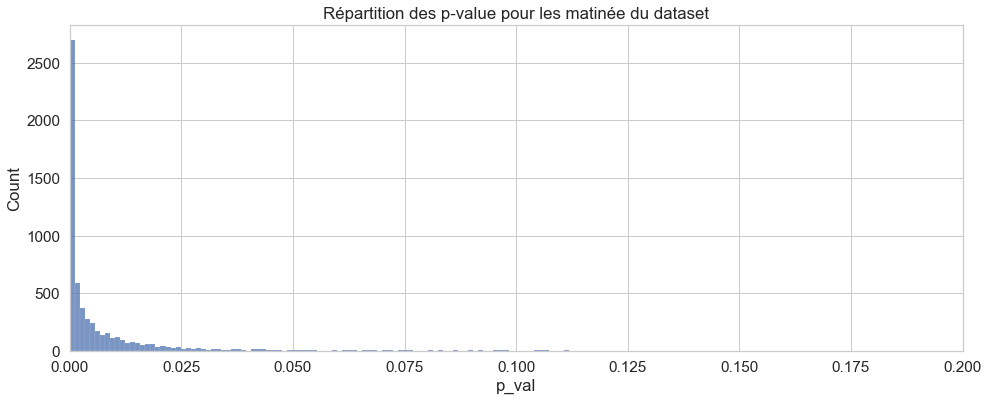

In [227]:
NbPvalUnder = dfStatTesAM[dfStatTesAM.p_val < 0.005]
NbPvalUpper = dfStatTesAM[dfStatTesAM.p_val > 0.005]

plt.figure(figsize=(16, 6))
sns.histplot(data=dfStatTesAM, x="p_val")
plt.title('Répartition des p-value pour les matinée du dataset')
plt.xlim(0, 0.2);

print('On dénombre',NbPvalUnder.shape[0], 'p-value inférieur à 5% et',NbPvalUpper.shape[0], 'supérieur à 5%')

On dénombre 1043 p-value inférieur à 5% et 5373 supérieur à 5%


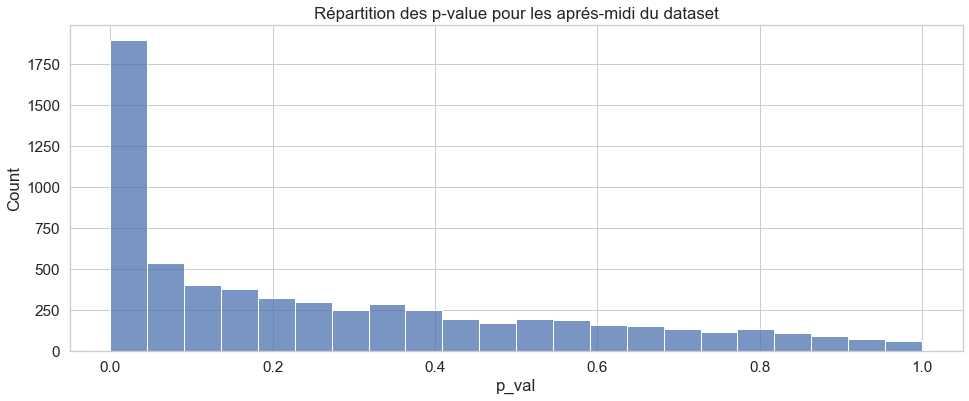

In [225]:
NbPvalUnder = dfStatTesPM[dfStatTesPM.p_val < 0.005]
NbPvalUpper = dfStatTesPM[dfStatTesPM.p_val > 0.005]

plt.figure(figsize=(16, 6))
sns.histplot(data=dfStatTesPM, x="p_val")
plt.title('Répartition des p-value pour les aprés-midi du dataset');

print('On dénombre',NbPvalUnder.shape[0], 'p-value inférieur à 5% et',NbPvalUpper.shape[0], 'supérieur à 5%')

## Conclusion

La tendance observée pour la journée du 4 février 2019 se confirme sur les autres dates et compteurs. Le nombre de p-value supérieur à 5% est plus important pour l'après-midi comparé au nombre du matin.

Le p-value calculé pour le matin et l'après-midi ne permettent pas de définir une loi Normale pour modéliser le comptage des vélos. Si l'on souhaite prévoir le nombre de vélos pour chaque compteur, il est préférable d'entrainer un modèle et d'en vérifier les performances afin de prédire au mieux le comptage des vélos pour chaque site.

In [229]:
Image(url= "https://media0.giphy.com/media/tNC2rod1uTrdC/giphy.gif")